# Projeto de Machine Learning II 
Projeto final do curso de Machine Learning II da Turma Santander Coders 2023 - Trilha de Data Science - Turma 1008.

Integrantes:
- [Anna Clara Amâncio](https://github.com/claraamancio)
- [Manusa Leal](https://github.com/manusaleal)

Este projeto possui como objetivo a realização da segmentação de clientes através de modelos não supervisionados.
A segmentação de clientes é importante para áreas como marketing e vendas dentro das empresas, pois desta forma é possível criar campanhas e melhores táticas de vendas com uma assertividade melhor.

O dataset possui informações demográficas relevantes dos clientes, sendo elas:

- *Sexo biológico*: 0: Masculino, 1: Feminino
- *Estado civil*: 0: Solteiro, 1: Não solteiro (divorciado/separado/casado/viúvo)
- *Idade*: Valor mínimo de 18, valor máximo de 78
- *Educação*: 0: outro/desconhecido, 1: ensino médio, 2: universidade, 3: pós-graduação
- *Renda*: Renda anual autodeclarada em dólares americanos do cliente (USD 35832 Valor mínimo e USD 309364 Valor máximo)
- *Ocupação*: 0: desempregado/não qualificado, 1: funcionário qualificado, 2: funcionário altamente qualificado
- *Tamanho do assentamento* (tamanho da cidade que o cliente reside baseado na quantidade de pessoas): 0: cidade pequena, 1: cidade média, 2: cidade grande

Fonte: https://www.kaggle.com/datasets/dev0914sharma/customer-clustering/code

# 1. Preparação dos Dados e Verificação de Consistência

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN, dbscan, KMeans, k_means, AgglomerativeClustering
#from yellowbrick.cluster import KElbowdf_edaizer 
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
#from yellowbrick.cluster import silhouette_df_edaizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings 
warnings.filterwarnings('ignore')

In [29]:
data = pd.read_csv('segmentation data.csv')
df = pd.DataFrame(data)
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


In [30]:
df.shape

(2000, 8)

In [31]:
df.columns

Index(['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size'],
      dtype='object')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [33]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise Exploratória de Dados

In [34]:
# Criando uma função para substituir os labels para os gráficos
def temp_df(df):
    temp_df = df.copy()
    temp_df = temp_df.rename(columns={"Sex": "Sexo", "Marital status": "Estado Civil", "Education": "Educação", 
                                      "Occupation": "Ocupação", "Settlement size": "Tamanho do Assentamento",
                                      "Age": "Idade", "Income": "Renda"})
    temp_df['Sexo'] = temp_df['Sexo'].replace(0, 'Masculino')
    temp_df['Sexo'] = temp_df['Sexo'].replace(1, 'Feminino')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(0, 'Solteiro')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(1, 'Não Solteiro')
    temp_df['Educação'] = temp_df['Educação'].replace(0, 'Outro/Desconhecido')
    temp_df['Educação'] = temp_df['Educação'].replace(1, 'Ensino Médio')
    temp_df['Educação'] = temp_df['Educação'].replace(2, 'Universidade')
    temp_df['Educação'] = temp_df['Educação'].replace(3, 'Pós-graduação')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(0, 'Desempregado/Não qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(1, 'Funcionário qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(2, 'Funcionário altamente qualificado')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(0, 'Cidade Pequena')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(1, 'Cidade Média')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(2, 'Cidade Grande')
    return temp_df

In [35]:
df_eda = temp_df(df)

In [36]:
df_eda

,ID,Sexo,Estado Civil,Idade,Educação,Renda,Ocupação,Tamanho do Assentamento
0,100000001,Masculino,Solteiro,67,Universidade,124670,Funcionário qualificado,Cidade Grande
1,100000002,Feminino,Não Solteiro,22,Ensino Médio,150773,Funcionário qualificado,Cidade Grande
2,100000003,Masculino,Solteiro,49,Ensino Médio,89210,Desempregado/Não qualificado,Cidade Pequena
3,100000004,Masculino,Solteiro,45,Ensino Médio,171565,Funcionário qualificado,Cidade Média
4,100000005,Masculino,Solteiro,53,Ensino Médio,149031,Funcionário qualificado,Cidade Média
...,...,...,...,...,...,...,...,...
1995,100001996,Feminino,Solteiro,47,Ensino Médio,123525,Desempregado/Não qualificado,Cidade Pequena
1996,100001997,Feminino,Não Solteiro,27,Ensino Médio,117744,Funcionário qualificado,Cidade Pequena
1997,100001998,Masculino,Solteiro,31,Outro/Desconhecido,86400,Desempregado/Não qualificado,Cidade Pequena
1998,100001999,Feminino,Não Solteiro,24,Ensino Médio,97968,Desempregado/Não qualificado,Cidade Pequena


### Distribuição das Variáveis Categóricas

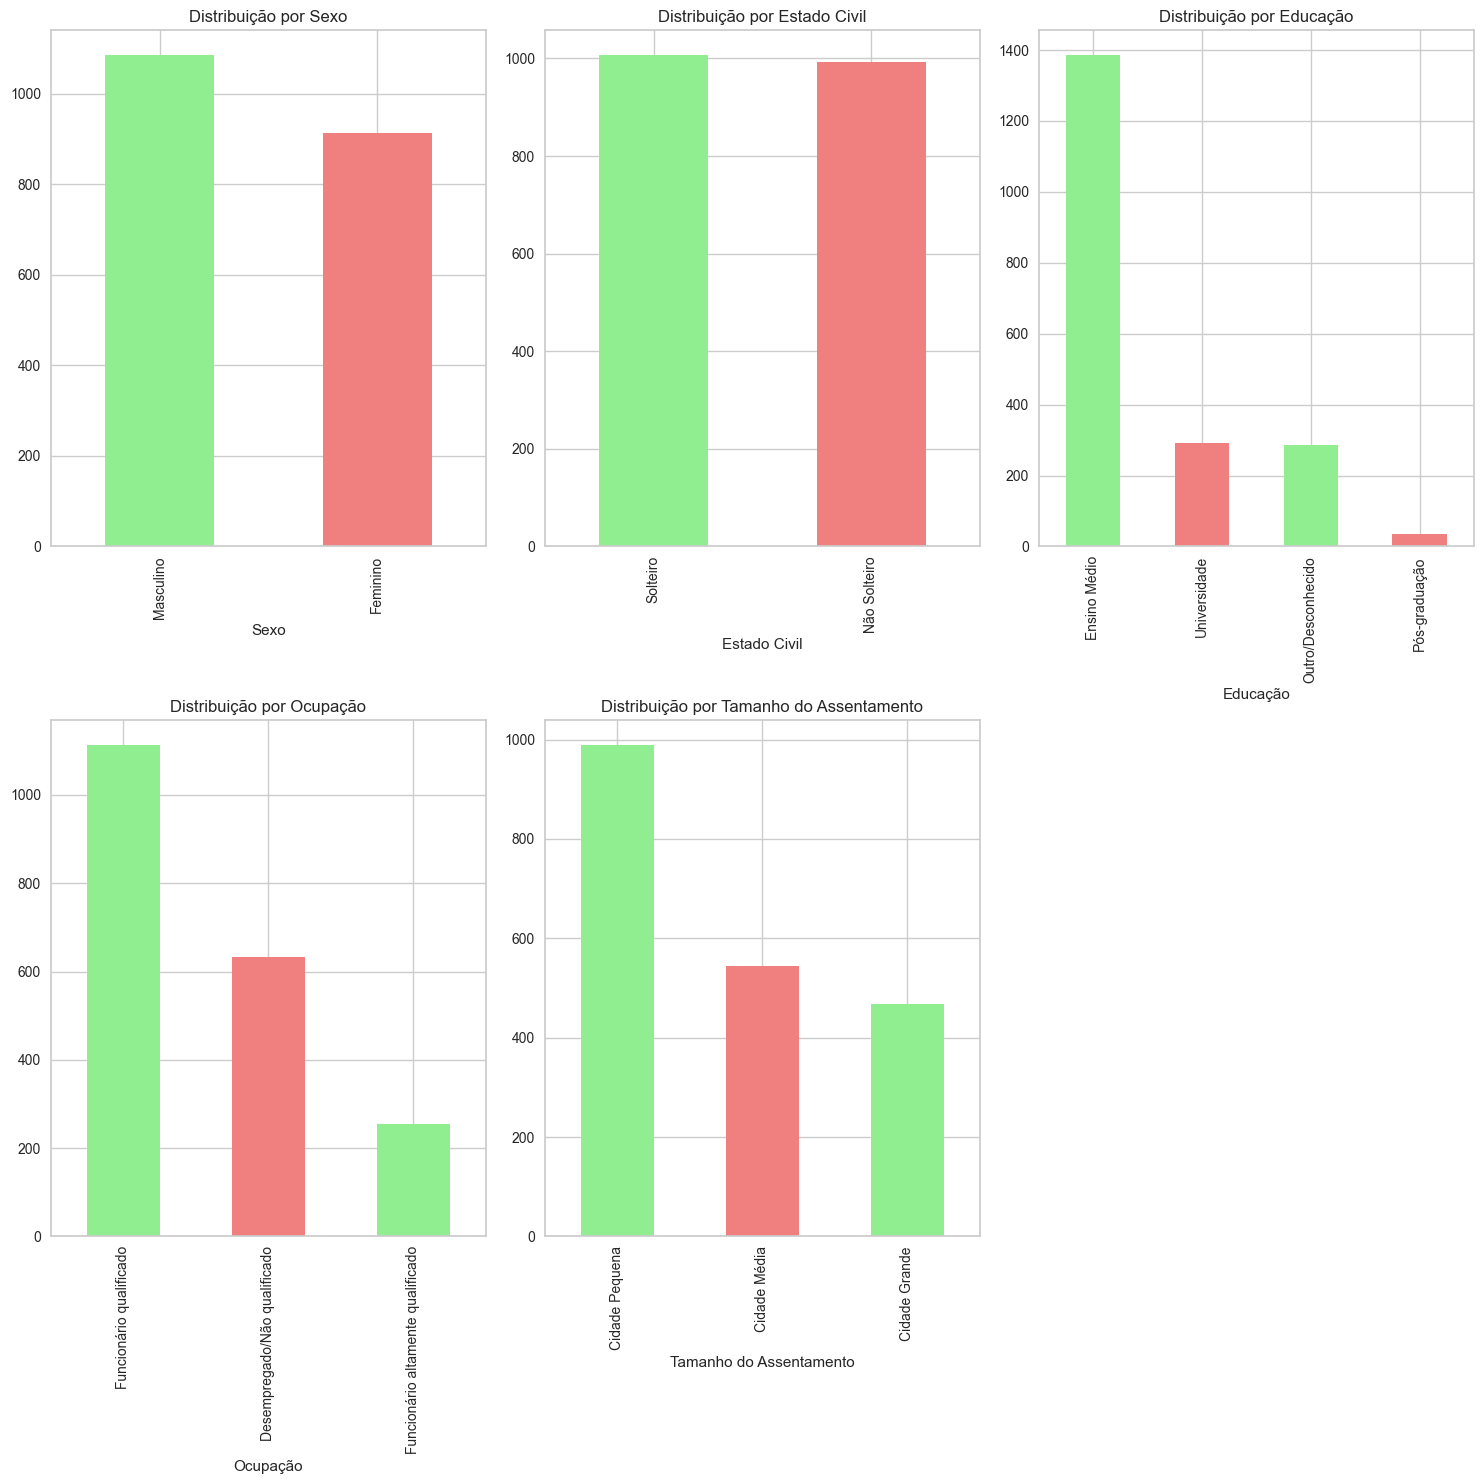

In [37]:
# Contando a ocorrência para cada categoria
sexo_counts = df_eda['Sexo'].value_counts()
estado_civil_counts = df_eda['Estado Civil'].value_counts()
educacao_counts = df_eda['Educação'].value_counts()
ocupacao_counts = df_eda['Ocupação'].value_counts()
assentamento_counts = df_eda['Tamanho do Assentamento'].value_counts()

paleta = ['lightgreen', 'lightcoral']

# Criando os subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Plot para 'Sexo'
sexo_counts.plot(kind='bar', ax=axes[0, 0], color=paleta)
axes[0, 0].set_title('Distribuição por Sexo')

# Plot para 'Estado Civil'
estado_civil_counts.plot(kind='bar', ax=axes[0, 1], color=paleta)
axes[0, 1].set_title('Distribuição por Estado Civil')

# Plot para 'Educação'
educacao_counts.plot(kind='bar', ax=axes[0, 2], color=paleta)
axes[0, 2].set_title('Distribuição por Educação')

# Plot para 'Ocupação'
ocupacao_counts.plot(kind='bar', ax=axes[1, 0], color=paleta)
axes[1, 0].set_title('Distribuição por Ocupação')

# Plot para 'Tamanho do Assentamento'
assentamento_counts.plot(kind='bar', ax=axes[1, 1], color=paleta)
axes[1, 1].set_title('Distribuição por Tamanho do Assentamento')

# Removendo subplots vazios
fig.delaxes(axes[1, 2])

# Ajuste de layout
plt.tight_layout()
plt.show()

- A Distribuição por Estado Civil é a que possui uma proporção melhor balanceada, seguida pelo Sexo. 

- Já a Educação, Ocupação e tamanho do Assentamento estão desbalanceados. 
- Na distribuição da Educação, grande quantidade de pessoas que possuem o Ensino Médio e menos de 50 pessoas possuem a pós graduação.

- Para a Ocupação, muitos funcionários qualificados e muitas pessoas são de Cidade Pequena.

### Distribuição das Variáveis Numéricas

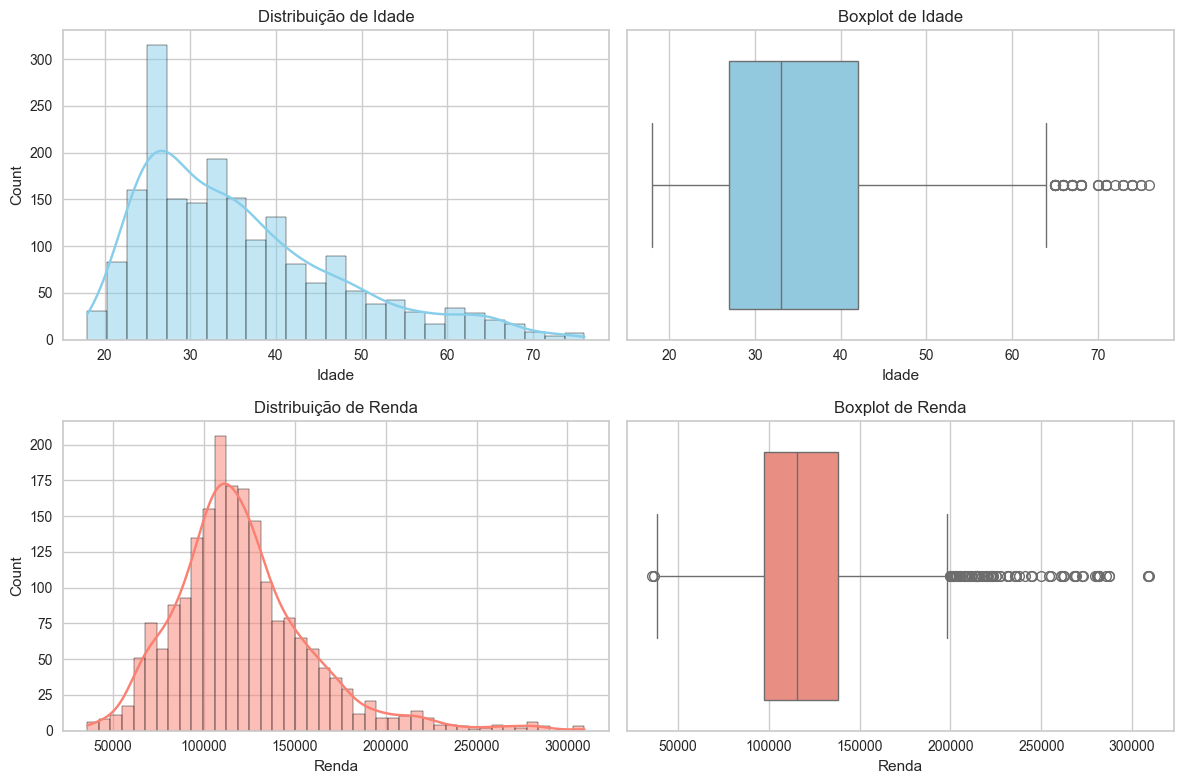

In [38]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Distribution plot for 'Idade'
sns.histplot(df_eda['Idade'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribuição de Idade')

# Boxplot for 'Idade'
sns.boxplot(x=df_eda['Idade'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot de Idade')

# Distribution plot for 'Renda'
sns.histplot(df_eda['Renda'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribuição de Renda')

# Boxplot for 'Renda'
sns.boxplot(x=df_eda['Renda'], ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Boxplot de Renda')

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
# Valores exatos da média e mediana
numeric_columns = df_eda[['Idade', 'Renda']]
numeric_columns.describe()

,Idade,Renda
count,2000.000000,2000.000000
mean,35.909000,120954.419000
std,11.719402,38108.824679
min,18.000000,35832.000000
25%,27.000000,97663.250000
50%,33.000000,115548.500000
75%,42.000000,138072.250000
max,76.000000,309364.000000


Observando a distribuição de idade, temos que o gráfico está deslocado para a esquerda, indicando que a média (35.9) é maior que a mediana. O boxplot indica que a mediana está próxima dos 33 anos, contendo alguns outliers no limite superior.

Já para a distribuição de renda, ela está levemente desloacada para a esquerda, tendo um boxplot com distribuição um pouco mais simétrico do que a idade. A maioria dos outliers estão no limite superior.

# Modelos de Clusterização não supervisionado

Vamos estudar os algoritmos KMeans, Hierárquico e DBScan. Primeiro, vamos investigar o melhor número de clusters a serem adotados nos modelos KMeans e Hierárquico utilizando o Método do Cotovelo e o melhor número epsilon a ser adotado nos modelos DBScan usando o Método dos Vizinhos Próximos. Depois, montaremos um DataFrame com as métricas de cada modelo, a fim de escolher o algoritmo ideal para o problema em questão.

In [40]:
# Drop da coluna 'ID'
df.drop('ID', axis=1, inplace=True)

In [41]:
# Verificação do drop
df.columns

Index(['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation',
       'Settlement size'],
      dtype='object')

### Encoding e Normalização dos DataFrame

In [42]:
# Encoding dos dados com StandardScaler
scaler_std = StandardScaler()
data_std = scaler_std.fit_transform(df)

# Normalização dos dados com MinMax
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(df)

### Redução de Dimensionalidade com a PCA

Text(0.5, 1.0, 'Variância explicada cumulativa vs nº de componentes')

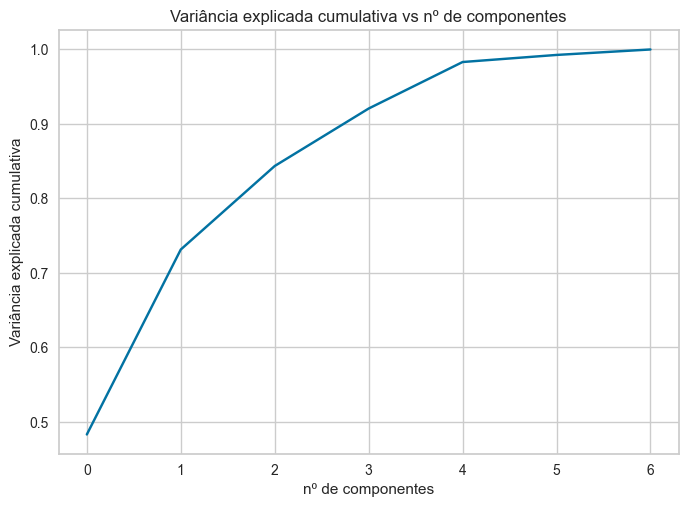

In [43]:
# Encontrando o melhor número de componentes 
pca = PCA().fit(data_minmax)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nº de componentes')
plt.ylabel('Variância explicada cumulativa')
plt.title ('Variância explicada cumulativa vs nº de componentes')

Analisando o gráfico acima, a quantidade de componentes que captura no mínimo, aproximadamente 95% da variância é 3 componentes. Poderíamos escolher 4 para ter melhor variância, porém com 3 componentes, conseguimos df_edaizar os dados. 

In [44]:
# Setando o modelo com n_components=3
pca = PCA(n_components=3)

# Fit transform para reduzir o dataset para 3 componentes
reduced_data = pca.fit_transform(data_minmax)

### Utilizando o dataset reduzido nos modelos de clusterização

#### Encontrando quantidade ideal de clusters (K-Means e Agrupamento Hierárquico)

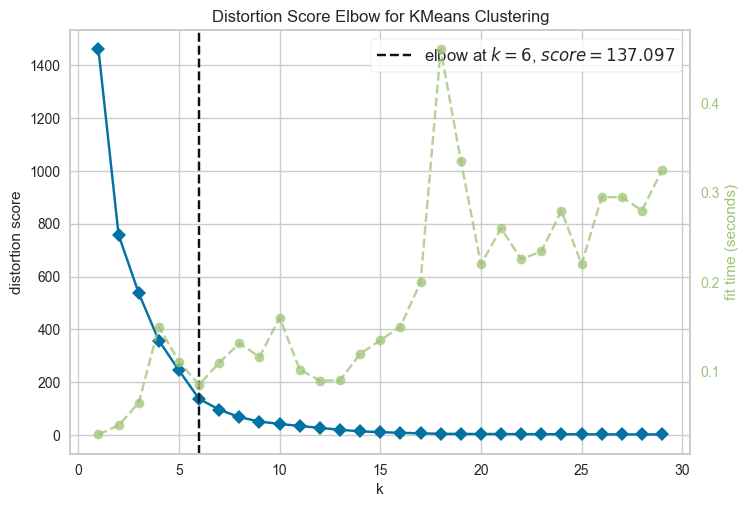

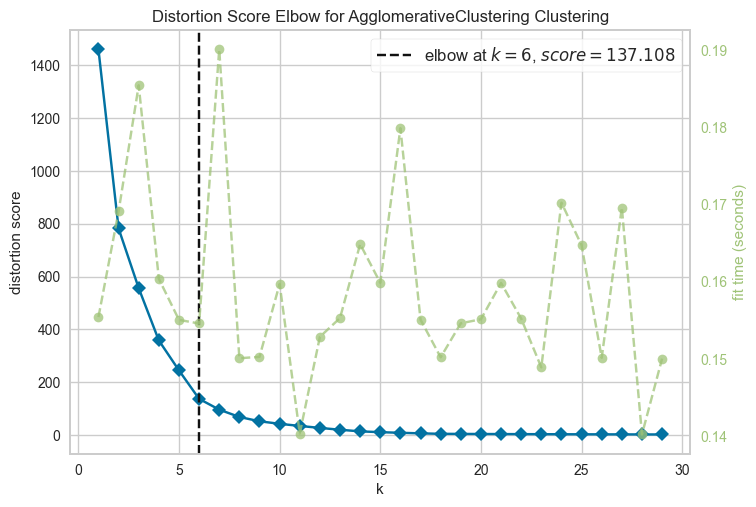

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
#================================ Encontrando a quantidade ideal de clusters ====================================

# Método do Cotovelo para o K-Means
kmeans = KMeans()
df_edaizer = KElbowVisualizer(kmeans, k = (1, 30)) 
df_edaizer.fit(reduced_data)
df_edaizer.show()

# Método do Cotovelo para o Agrupamento Hierárquico
aglo = AgglomerativeClustering()
df_edaizer = KElbowVisualizer(aglo, k = (1, 30)) 
df_edaizer.fit(reduced_data)
df_edaizer.show()

Para o algoritmo KMeans e para o algoritmo hierárquico o melhor número de clusters a ser utilizado é 6. 

#### Encontrando epsilon ideal para DBSCAN

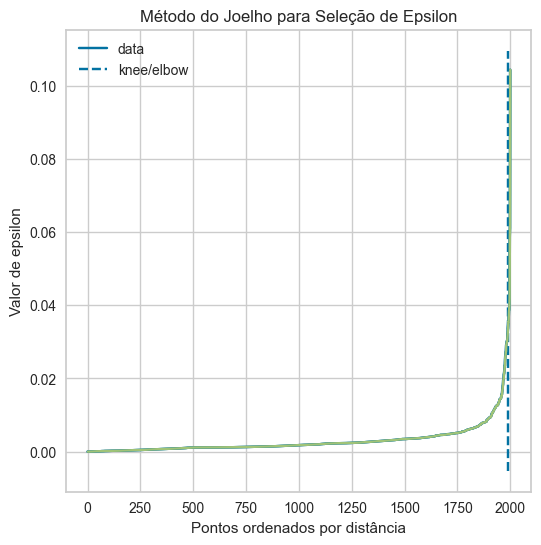

In [46]:
# Método dos Vizinhos Próximos - Melhor valor de Epsilon para DBSCAN 
neighbors = NearestNeighbors(n_neighbors = 100)
neighbors_fit = neighbors.fit(reduced_data)
distances, indices = neighbors_fit.kneighbors(reduced_data)
distances = np.sort(distances, axis = 0)

kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances[:, 1], S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

kneedle.plot_knee()
plt.plot(distances[:, 1])
plt.plot(list(range(1, len(distances) + 1)), distances[:, 1])
plt.title('Método do Joelho para Seleção de Epsilon')
plt.xlabel("Pontos ordenados por distância")
plt.ylabel("Valor de epsilon")
plt.show()

Iremos adotar o valor 0.04 para o parâmetro episilon e 100 para o parâmetro min_samples no algoritmo DBScan.

# Tunando e escolhendo o modelo com os melhores hiperparâmetros

## K-Means

Vamos explorar os hiperparâmetros do algoritmo KMeans a fim de encontrar o modelo tunado.

Parâmetros de interesse:
- **n_clusters**: Número de clusters *(já encontrado anteriormente)*.
- **init**: Método para inicialização *(k-means++, random)*.
- **n_init**: Número de vezes que o algoritmo roda com diferentes centroides *(auto ou int, default=10)*. 
- **max_iter**: Máximo número de iterações para o algoritmo para cada rodada *(int, default=300)*.

Vamos criar todas as combinações usando os possíveis valores para cada parâmetro:

init = ['k-means++', 'random']

n_init = [5, 10, 15, 20]

max_iter = [100, 300, 500]

In [47]:
# Parâmetros e seus valores
parameters_grid = {
    "init": ['k-means++', 'random'],
    "n_init": [5, 10, 15, 20],
    "max_iter": [100,300,500]
}

# Gerando todas as combinações
keys, values = zip(*parameters_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Dicinário para guardarmos os resultados
resultado_kmeans = {
    "Init": [],
    "N_init": [],
    "Max_iter": [],
    "Silhouette Score": [],
    "Davies-Bouldin Score": [], 
    "Tempo": []
}

# Função que avalia K-Means usando a métrica Silhouette Score
def avalia_kmeans(combinacoes, resultados, data):
    for combinacao in combinacoes:
        if combinacao['init']=='k-means++':
            algoritmo = KMeans(**combinacao, n_clusters=6)
            start_time = time.time()
            algoritmo.fit(data)
            end_time = time.time()
            fitting_time = end_time - start_time
            resultados["Init"].append(combinacao["init"])
            resultados["N_init"].append(combinacao["n_init"])
            resultados["Max_iter"].append(combinacao["max_iter"])
            resultados["Silhouette Score"].append(silhouette_score(data, algoritmo.labels_))
            resultados["Davies-Bouldin Score"].append(davies_bouldin_score(data, algoritmo.labels_))
            resultados["Tempo"].append(fitting_time)
        else: #Random não possui n_int definido
            algoritmo = KMeans(**combinacao)
            start_time = time.time()
            algoritmo.fit(data)
            end_time = time.time()
            fitting_time = end_time - start_time
            resultados["Init"].append(combinacao["init"])
            resultados["N_init"].append(combinacao["n_init"])
            resultados["Max_iter"].append(combinacao["max_iter"])
            resultados["Silhouette Score"].append(silhouette_score(data, algoritmo.labels_))
            resultados["Davies-Bouldin Score"].append(davies_bouldin_score(data, algoritmo.labels_))
            resultados["Tempo"].append(fitting_time)
    return resultados

# Gerando DataFrame de resultados
resultados_kmeans = avalia_kmeans(permutations_dicts, resultado_kmeans, reduced_data)
df_kmeans = pd.DataFrame(resultados_kmeans)
df_kmeans

,Init,N_init,Max_iter,Silhouette Score,Davies-Bouldin Score,Tempo
0,k-means++,5,100,0.675635,0.520127,0.050292
1,k-means++,5,300,0.675635,0.520127,0.033340
2,k-means++,5,500,0.675635,0.520127,0.029804
3,k-means++,10,100,0.675635,0.520127,0.055082
4,k-means++,10,300,0.675635,0.520127,0.069920
5,k-means++,10,500,0.675635,0.520127,0.050073
6,k-means++,15,100,0.675635,0.520127,0.085138
7,k-means++,15,300,0.675635,0.520127,0.099821
8,k-means++,15,500,0.675635,0.520127,0.094912
9,k-means++,20,100,0.675635,0.520127,0.110096


### Silhouette Score

É uma métrica usada para medir o quão bem cada amostra se ajusta ao cluster ao qual foi designada. A métrica assume valores no intervalo [-1,1]. Valores mais próximos de 1 nos indicam que os dados estão bem agrupados. 


### Davies-Bouldin Score 

É uma métrica usada para medir o quanto dois clusters são similares. Quanto mais baixo o valor da métrica, temos que os clusters estão bem distintos e bem agrupados.

In [49]:
# Índice de máximo Silhouette Score
max_silhouette_index = df_kmeans['Silhouette Score'].idxmax()

# Índice de mínimo Davies-Bouldin Score
min_davies_bouldin_index = df_kmeans['Davies-Bouldin Score'].idxmin()

# Índice Menor tempo para último critério de desempate
tempo = df_kmeans.loc[[max_silhouette_index, min_davies_bouldin_index]]['Tempo'].idxmin()

best_params={}
# Checkando se os índices são iguais
if max_silhouette_index == min_davies_bouldin_index:
    best_params.update({'kmeans': df_kmeans.loc[max_silhouette_index]})
else:
    # Se diferentes, o tempo mínimo desempata
    best_params.update({'kmeans': df_kmeans.loc[tempo]})

best_params


{'kmeans': Init                      random
 N_init                        20
 Max_iter                     500
 Silhouette Score        0.699426
 Davies-Bouldin Score    0.392896
 Tempo                   0.075341
 Name: 23, dtype: object}

## Agrupamento Hierárquico

Vamos explorar os hiperparâmetros do algoritmo hierárquico a fim de encontrar o modelo tunado.

Parâmetros de interesse:
- **n_clusters**: Número de clusters *(já encontrado anteriormente)*.
- **affinity**: Distância entre instâncias *(euclidean, manhattan, minkowski)*. 
- **linkage**: Critério de ligação *(single, complete, average)*.

Vamos criar todas as combinações usando os possíveis valores para cada parâmetro:

linkage = ['single', 'complete', 'average']

affinity = ['euclidean', 'manhattan', 'minkowski']


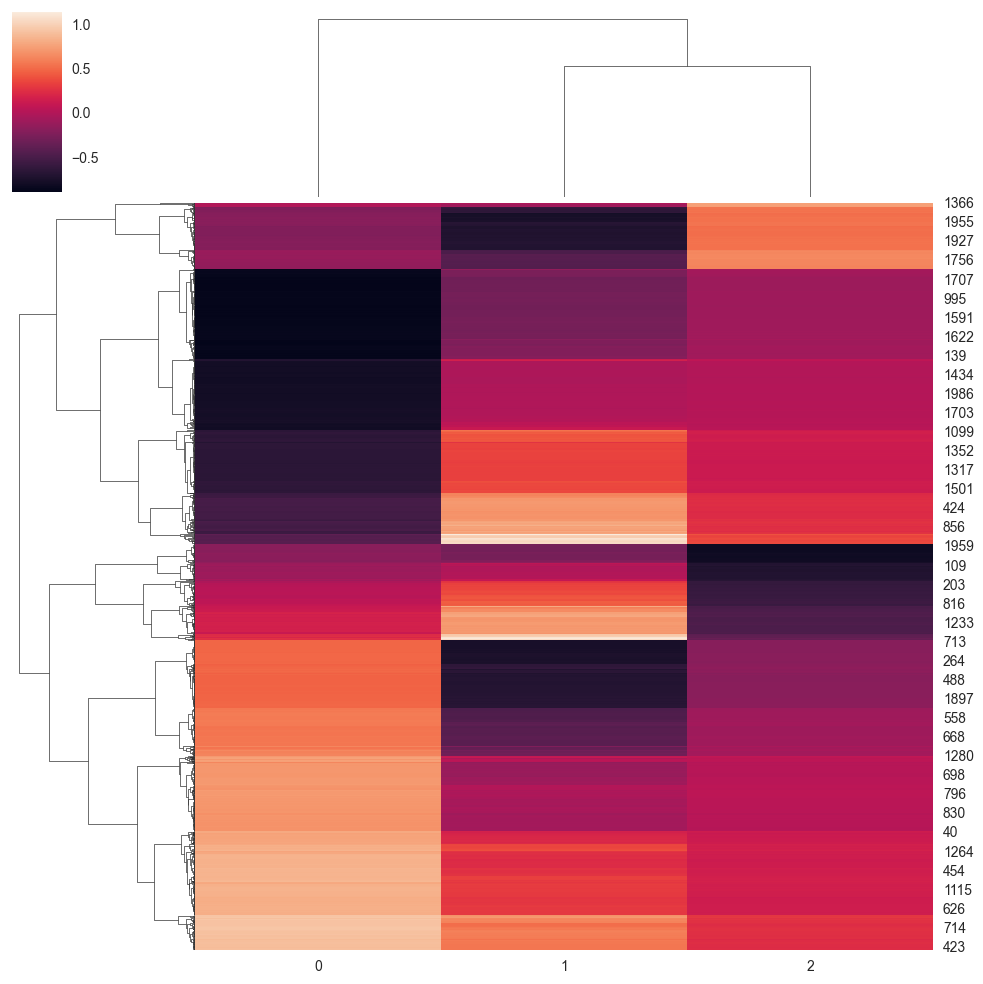

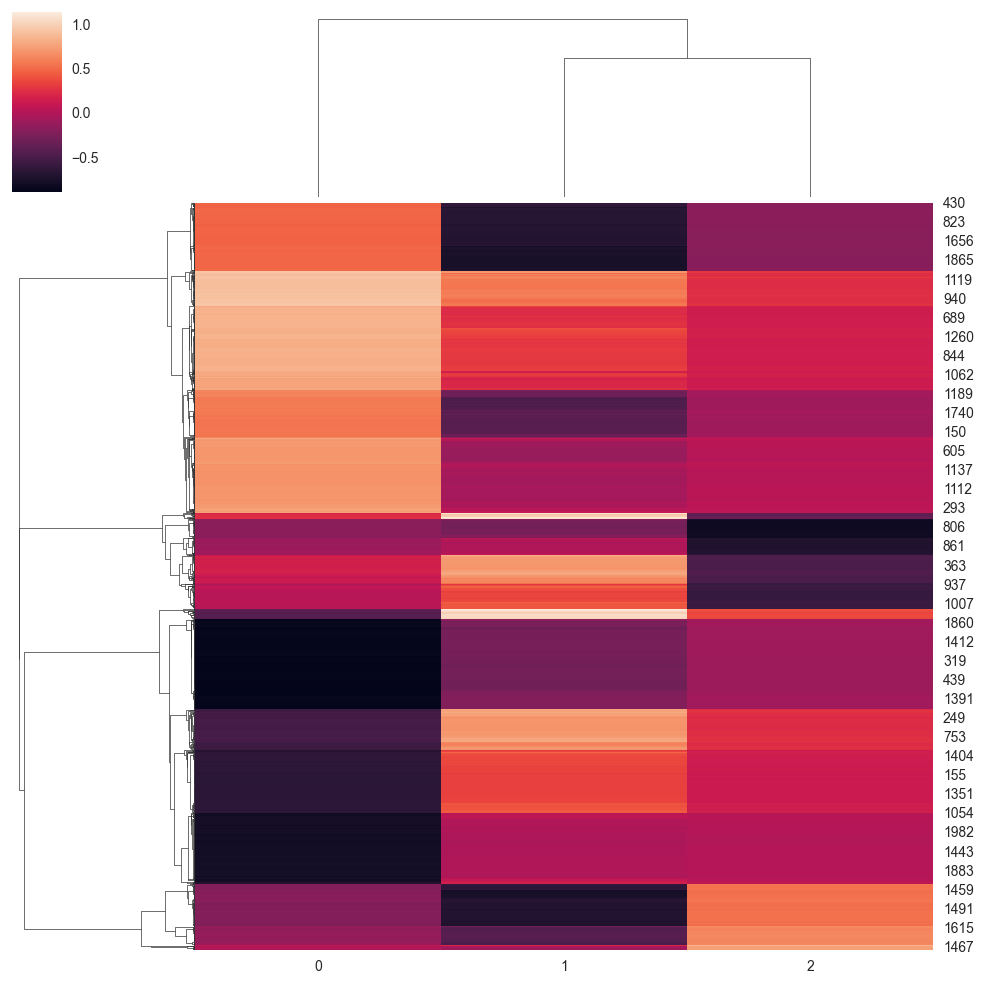

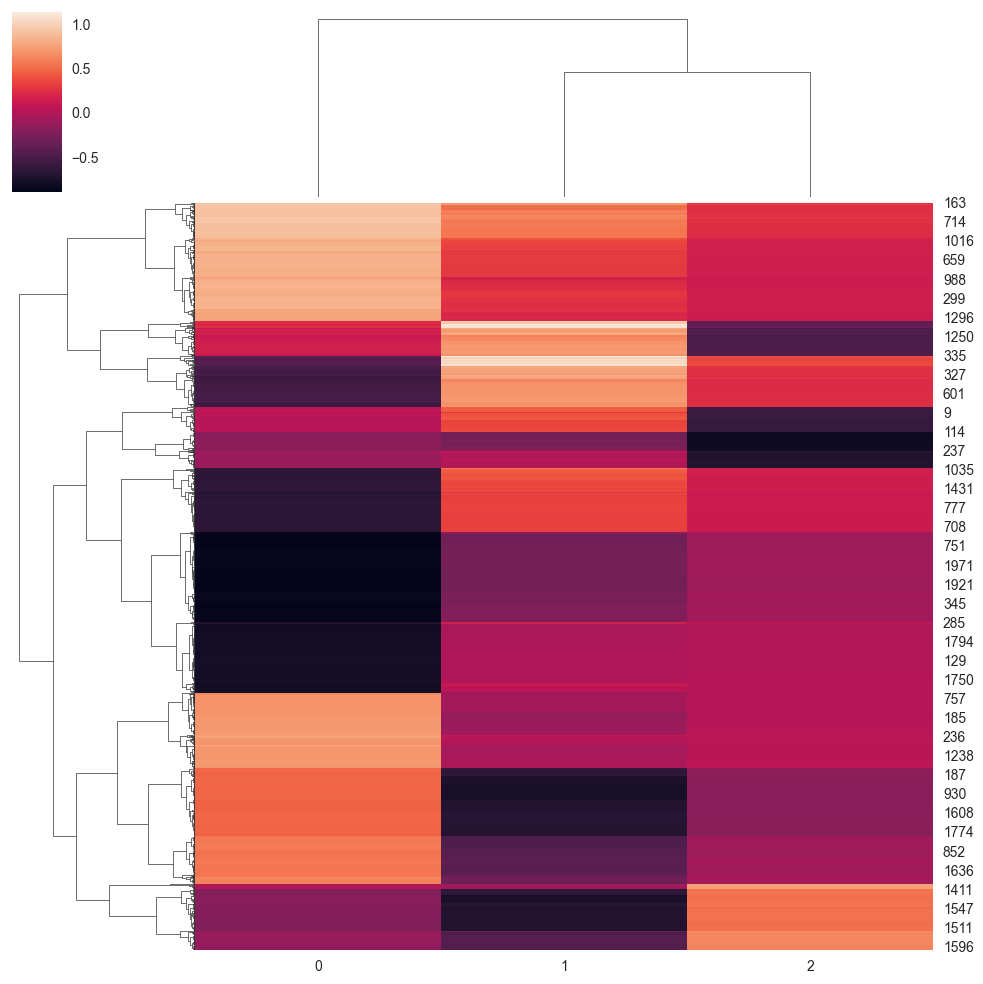

In [50]:
# Dendrograma - Average Link
sns.clustermap(reduced_data, method='average')  # metric = 'euclidean'

# Dendrograma - Single Link
sns.clustermap(reduced_data, method='single')  # metric = 'euclidean'

# Dendrograma - Complete Link
sns.clustermap(reduced_data, method='complete')  # metric = 'euclidean'

In [51]:
# Parâmetros e seus valores
parameters_grid = {
    "linkage": ['single', 'complete', 'average'],
    "affinity": ['euclidean', 'manhattan', 'minkowski']
}

# Gerando todas as combinações
keys, values = zip(*parameters_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Dicinário para guardarmos os resultados
resultado_hierarquico = {
    "Link": [],
    "Distância": [],
    "Silhouette Score": [],
    "Davies-Bouldin Score": [], 
    "Tempo": []
}

def avalia_hierarquico(combinacoes, resultados, data): 
    for combinacao in combinacoes:
        algoritmo = AgglomerativeClustering(**combinacao, n_clusters=6)
        start_time = time.time()
        algoritmo.fit(data)
        end_time = time.time()
        fitting_time = end_time - start_time
        resultados["Link"].append(combinacao["linkage"])
        resultados["Distância"].append(combinacao["affinity"])
        resultados["Silhouette Score"].append(silhouette_score(data, algoritmo.labels_))
        resultados["Davies-Bouldin Score"].append(davies_bouldin_score(data, algoritmo.labels_))
        resultados["Tempo"].append(fitting_time)
    return resultados

# Gerando DataFrame de resultados
resultados_hierarquico = avalia_hierarquico(permutations_dicts, resultado_hierarquico, reduced_data)
df_hierarquico = pd.DataFrame(resultados_hierarquico)
df_hierarquico
    

,Link,Distância,Silhouette Score,Davies-Bouldin Score,Tempo
0,single,euclidean,0.521056,0.603818,0.119870
1,single,manhattan,0.521056,0.603818,0.100068
2,single,minkowski,0.521056,0.603818,0.123888
3,complete,euclidean,0.588180,0.660642,0.194963
4,complete,manhattan,0.591260,0.581480,0.210327
5,complete,minkowski,0.588180,0.660642,0.205096
6,average,euclidean,0.633510,0.496603,0.190294
7,average,manhattan,0.633510,0.496603,0.174858
8,average,minkowski,0.633510,0.496603,0.214492


In [52]:
# Encontrando os modelos mais eficientes considerando as métricas
# Índice de máximo Silhouette Score
max_silhouette_index = df_hierarquico['Silhouette Score'].idxmax()

# Índice de mínimo Davies-Bouldin Score
min_davies_bouldin_index = df_hierarquico['Davies-Bouldin Score'].idxmin()

# Índice Menor tempo para último critério de desempate
tempo = df_kmeans.loc[[max_silhouette_index, min_davies_bouldin_index]]['Tempo'].idxmin()

# Checkando se os índices são iguais
if max_silhouette_index == min_davies_bouldin_index:
    best_params.update({'hierarquico': df_hierarquico.loc[max_silhouette_index]})
else:
    # Se diferentes, o tempo mínimo desempata
    best_params.update({'hierarquico': df_hierarquico.loc[tempo]}) 

best_params


{'kmeans': Init                      random
 N_init                        20
 Max_iter                     500
 Silhouette Score        0.699426
 Davies-Bouldin Score    0.392896
 Tempo                   0.075341
 Name: 23, dtype: object,
 'hierarquico': Link                      average
 Distância               euclidean
 Silhouette Score          0.63351
 Davies-Bouldin Score     0.496603
 Tempo                    0.190294
 Name: 6, dtype: object}

In [53]:
df_hierarquico.loc[[max_silhouette_index, min_davies_bouldin_index]]['Tempo'].idxmin()

6

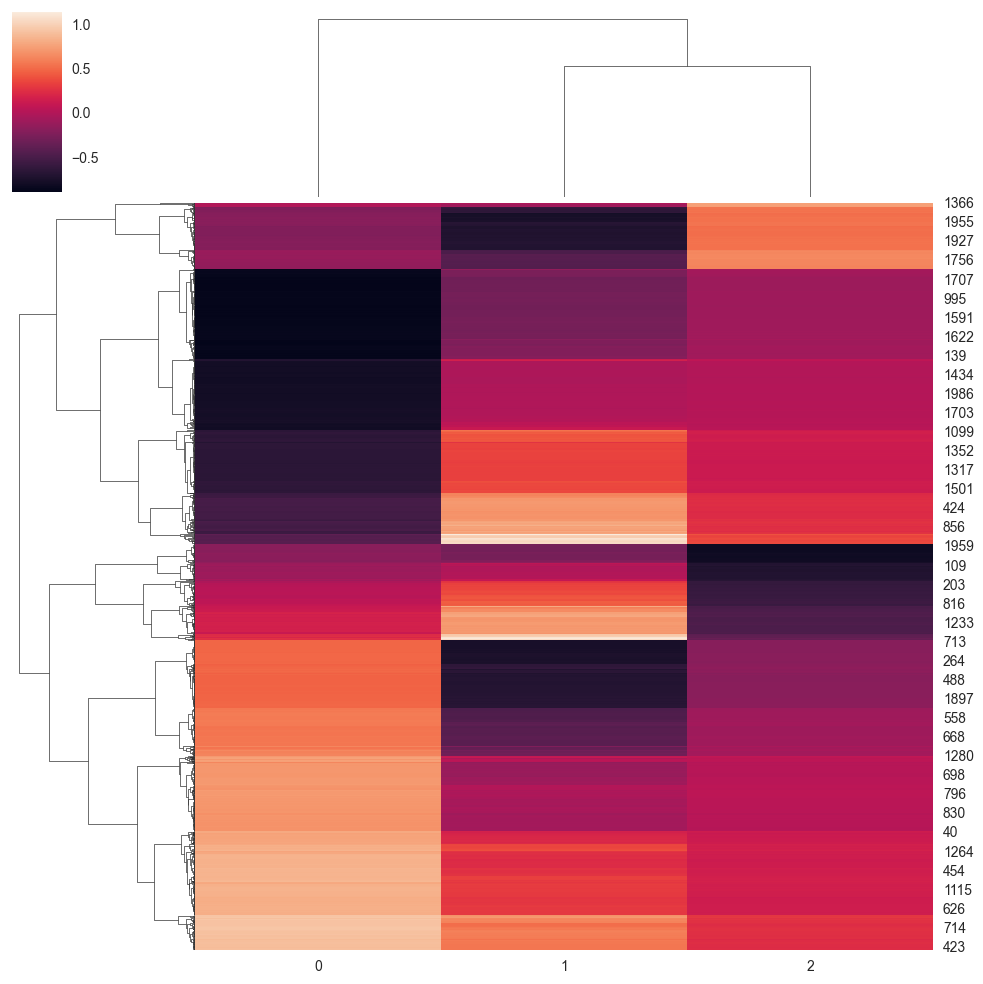

In [54]:
# Dendrograma do melhor modelo
sns.clustermap(reduced_data, method='average', metric='euclidean')  

## DBSCAN

In [55]:
# Parâmetros e seus valores
parameters_grid = {
    "min_samples": [10, 50, 100],
    "metric": ['euclidean', 'manhattan']
}

# Gerando todas as combinações
keys, values = zip(*parameters_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Dicinário para guardarmos os resultados
resultado_dbscan = {
    "Min_Samples": [],
    "Distância": [],
    "Silhouette Score": [],
    "Davies-Bouldin Score": [], 
    "Tempo": []
}

def avalia_dbscan(combinacoes, resultados, data): 
    for combinacao in combinacoes:
        algoritmo = DBSCAN(**combinacao, eps=0.04)
        start_time = time.time()
        algoritmo.fit(data)
        end_time = time.time()
        fitting_time = end_time - start_time
        resultados["Min_Samples"].append(combinacao["min_samples"])
        resultados["Distância"].append(combinacao["metric"])
        resultados["Silhouette Score"].append(silhouette_score(data, algoritmo.labels_))
        resultados["Davies-Bouldin Score"].append(davies_bouldin_score(data, algoritmo.labels_))
        resultados["Tempo"].append(fitting_time)
    return resultados

# Gerando DataFrame de resultados
resultados_dbscan = avalia_dbscan(permutations_dicts, resultado_dbscan, reduced_data)
df_dbscan = pd.DataFrame(resultados_dbscan)
df_dbscan

,Min_Samples,Distância,Silhouette Score,Davies-Bouldin Score,Tempo
0,10,euclidean,0.762001,1.047142,0.094678
1,10,manhattan,0.599055,0.970939,0.048561
2,50,euclidean,0.499535,0.960062,0.053686
3,50,manhattan,0.207820,1.025641,0.030021
4,100,euclidean,0.198575,1.137567,0.055026
5,100,manhattan,0.252188,0.782438,0.039922


In [57]:
max_silhouette_index = df_dbscan['Silhouette Score'].idxmax()
min_davies_bouldin_index = df_dbscan['Davies-Bouldin Score'].idxmin()
df_dbscan.loc[[max_silhouette_index, min_davies_bouldin_index]]['Tempo'].idxmin()

5

In [58]:
# Encontrando os modelos mais eficientes considerando as métricas
# Índice de máximo Silhouette Score
max_silhouette_index = df_dbscan['Silhouette Score'].idxmax()

# Índice de mínimo Davies-Bouldin Score
min_davies_bouldin_index = df_dbscan['Davies-Bouldin Score'].idxmin()

# Índice Menor tempo para último critério de desempate
tempo = df_kmeans.loc[[max_silhouette_index, min_davies_bouldin_index]]['Tempo'].idxmin()

# Checkando se os índices são iguais
if max_silhouette_index == min_davies_bouldin_index:
    best_params.update({'dbscan': df_dbscan.loc[max_silhouette_index]})
else:
    # Se diferentes, o tempo mínimo desempata
    best_params.update({'dbscan': df_dbscan.loc[tempo]}) 

best_params


{'kmeans': Init                      random
 N_init                        20
 Max_iter                     500
 Silhouette Score        0.699426
 Davies-Bouldin Score    0.392896
 Tempo                   0.075341
 Name: 23, dtype: object,
 'hierarquico': Link                      average
 Distância               euclidean
 Silhouette Score          0.63351
 Davies-Bouldin Score     0.496603
 Tempo                    0.190294
 Name: 6, dtype: object,
 'dbscan': Min_Samples                   100
 Distância               manhattan
 Silhouette Score         0.252188
 Davies-Bouldin Score     0.782438
 Tempo                    0.039922
 Name: 5, dtype: object}

Deste modo, o k-means possui melhores scores tanto no Silhouette Score quanto no DBI.

# Escolha do melhor modelo - K- Means

OBS: A cada vez em que se rodava o código era obtido algum algoritmo diferente por conta do tempo.

Quantidade de clusters: 8


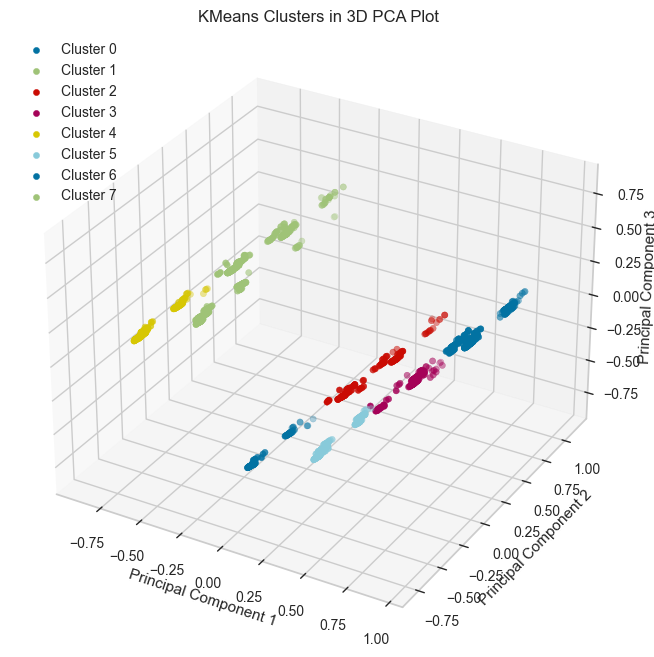

In [59]:
# Inicianlizando modelo
kmeans = KMeans( init = best_params['kmeans']['Init'], 
                n_init =best_params['kmeans']['N_init'], 
                max_iter = best_params['kmeans']['Max_iter'])

# Fitando modelo
kmeans.fit(reduced_data)

# Quantidade de Clusters 
labels = kmeans.labels_
print(f'Quantidade de clusters: {len(np.unique(labels))}')

# Get the cluster centers
centers = kmeans.cluster_centers_

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in range(len(np.unique(labels))):
    cluster_points = reduced_data[labels == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_label}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('KMeans Clusters in 3D PCA Plot')

# Adjust the legend position
ax.legend(loc='upper left')

plt.show()

# Análise dos Clusters

In [60]:
#Inserindo os labels no DataFrame
df_eda['Personas'] = labels
df_eda

,ID,Sexo,Estado Civil,Idade,Educação,Renda,Ocupação,Tamanho do Assentamento,Personas
0,100000001,Masculino,Solteiro,67,Universidade,124670,Funcionário qualificado,Cidade Grande,0
1,100000002,Feminino,Não Solteiro,22,Ensino Médio,150773,Funcionário qualificado,Cidade Grande,1
2,100000003,Masculino,Solteiro,49,Ensino Médio,89210,Desempregado/Não qualificado,Cidade Pequena,5
3,100000004,Masculino,Solteiro,45,Ensino Médio,171565,Funcionário qualificado,Cidade Média,3
4,100000005,Masculino,Solteiro,53,Ensino Médio,149031,Funcionário qualificado,Cidade Média,3
...,...,...,...,...,...,...,...,...,...
1995,100001996,Feminino,Solteiro,47,Ensino Médio,123525,Desempregado/Não qualificado,Cidade Pequena,7
1996,100001997,Feminino,Não Solteiro,27,Ensino Médio,117744,Funcionário qualificado,Cidade Pequena,4
1997,100001998,Masculino,Solteiro,31,Outro/Desconhecido,86400,Desempregado/Não qualificado,Cidade Pequena,5
1998,100001999,Feminino,Não Solteiro,24,Ensino Médio,97968,Desempregado/Não qualificado,Cidade Pequena,4


In [62]:
df_eda[['Personas', 'Idade', 'Renda']].groupby('Personas').median()

,Idade,Renda
Personas,,
0,37.0,143468.5
1,29.0,126778.5
2,32.0,130776.5
3,37.0,127557.5
4,28.5,102323.5
5,36.0,101270.0
6,29.0,94947.0
7,34.5,101511.0


In [63]:
df_eda.columns

Index(['ID', 'Sexo', 'Estado Civil', 'Idade', 'Educação', 'Renda', 'Ocupação',
       'Tamanho do Assentamento', 'Personas'],
      dtype='object')

In [64]:
df_eda[['Personas', 'Sexo', 'Estado Civil', 'Educação', 'Ocupação', 'Tamanho do Assentamento',]].groupby('Personas').agg(lambda x: x.mode().iloc[0])

,Sexo,Estado Civil,Educação,Ocupação,Tamanho do Assentamento
Personas,,,,,
0,Masculino,Solteiro,Ensino Médio,Funcionário qualificado,Cidade Grande
1,Feminino,Não Solteiro,Ensino Médio,Funcionário qualificado,Cidade Média
2,Masculino,Não Solteiro,Ensino Médio,Funcionário qualificado,Cidade Grande
3,Masculino,Solteiro,Ensino Médio,Funcionário qualificado,Cidade Média
4,Feminino,Não Solteiro,Ensino Médio,Desempregado/Não qualificado,Cidade Pequena
5,Masculino,Solteiro,Ensino Médio,Desempregado/Não qualificado,Cidade Pequena
6,Masculino,Não Solteiro,Ensino Médio,Desempregado/Não qualificado,Cidade Pequena
7,Feminino,Solteiro,Ensino Médio,Desempregado/Não qualificado,Cidade Pequena


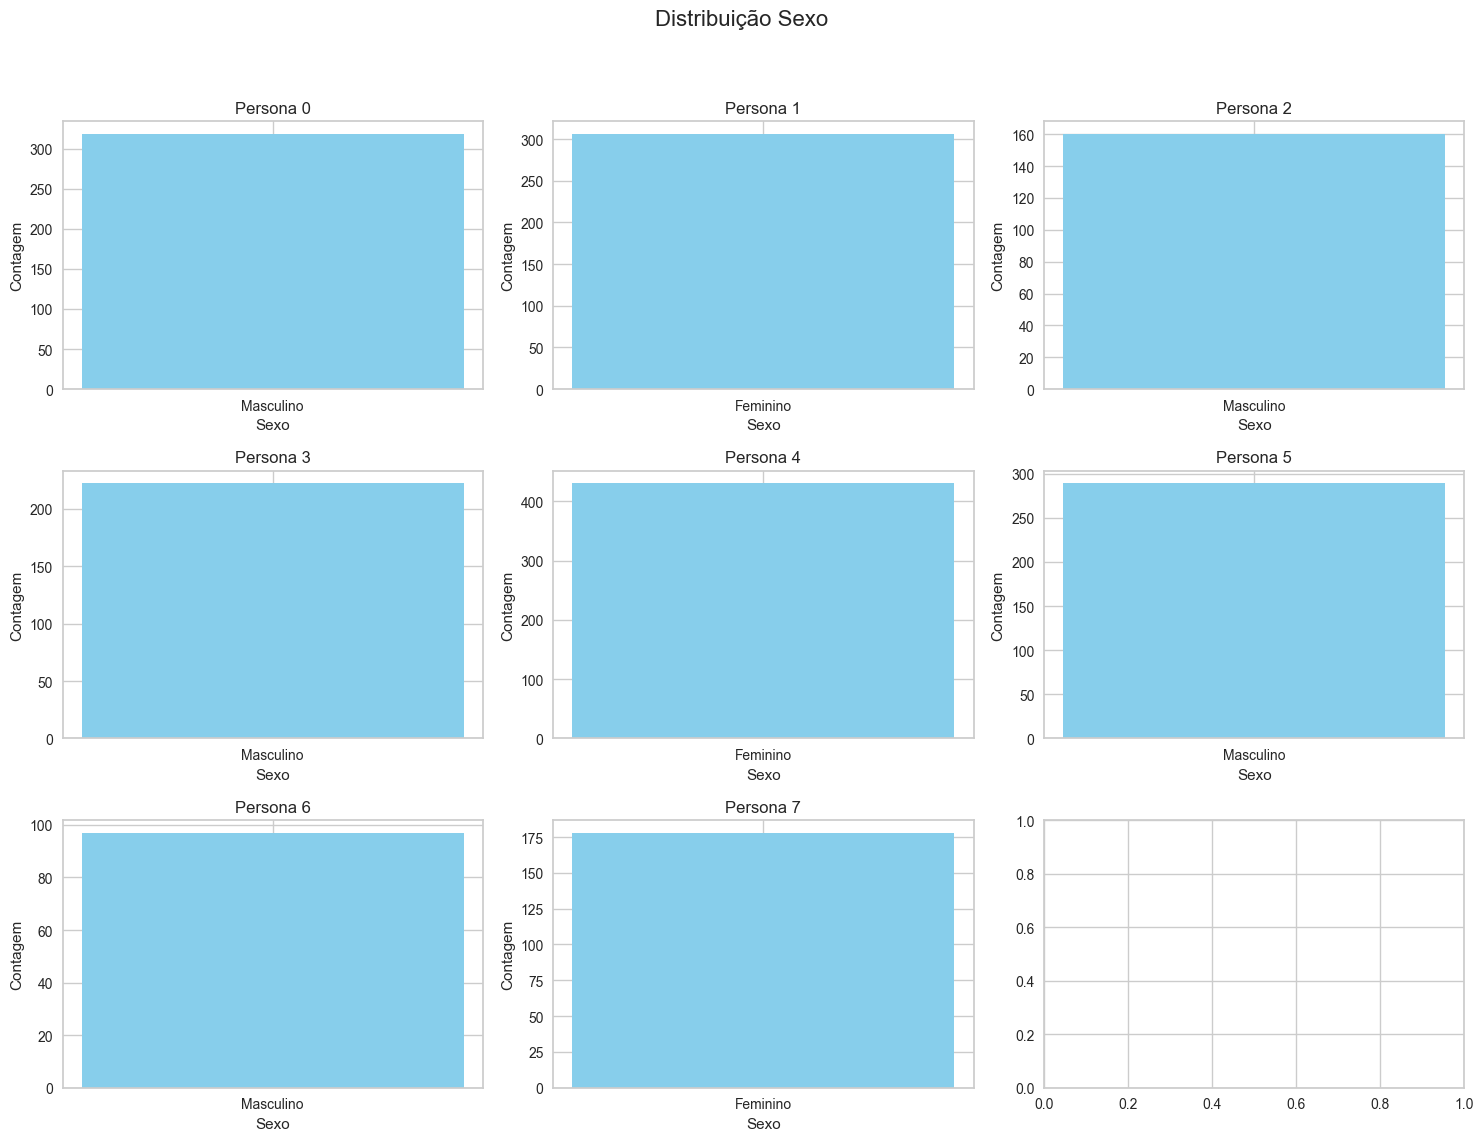

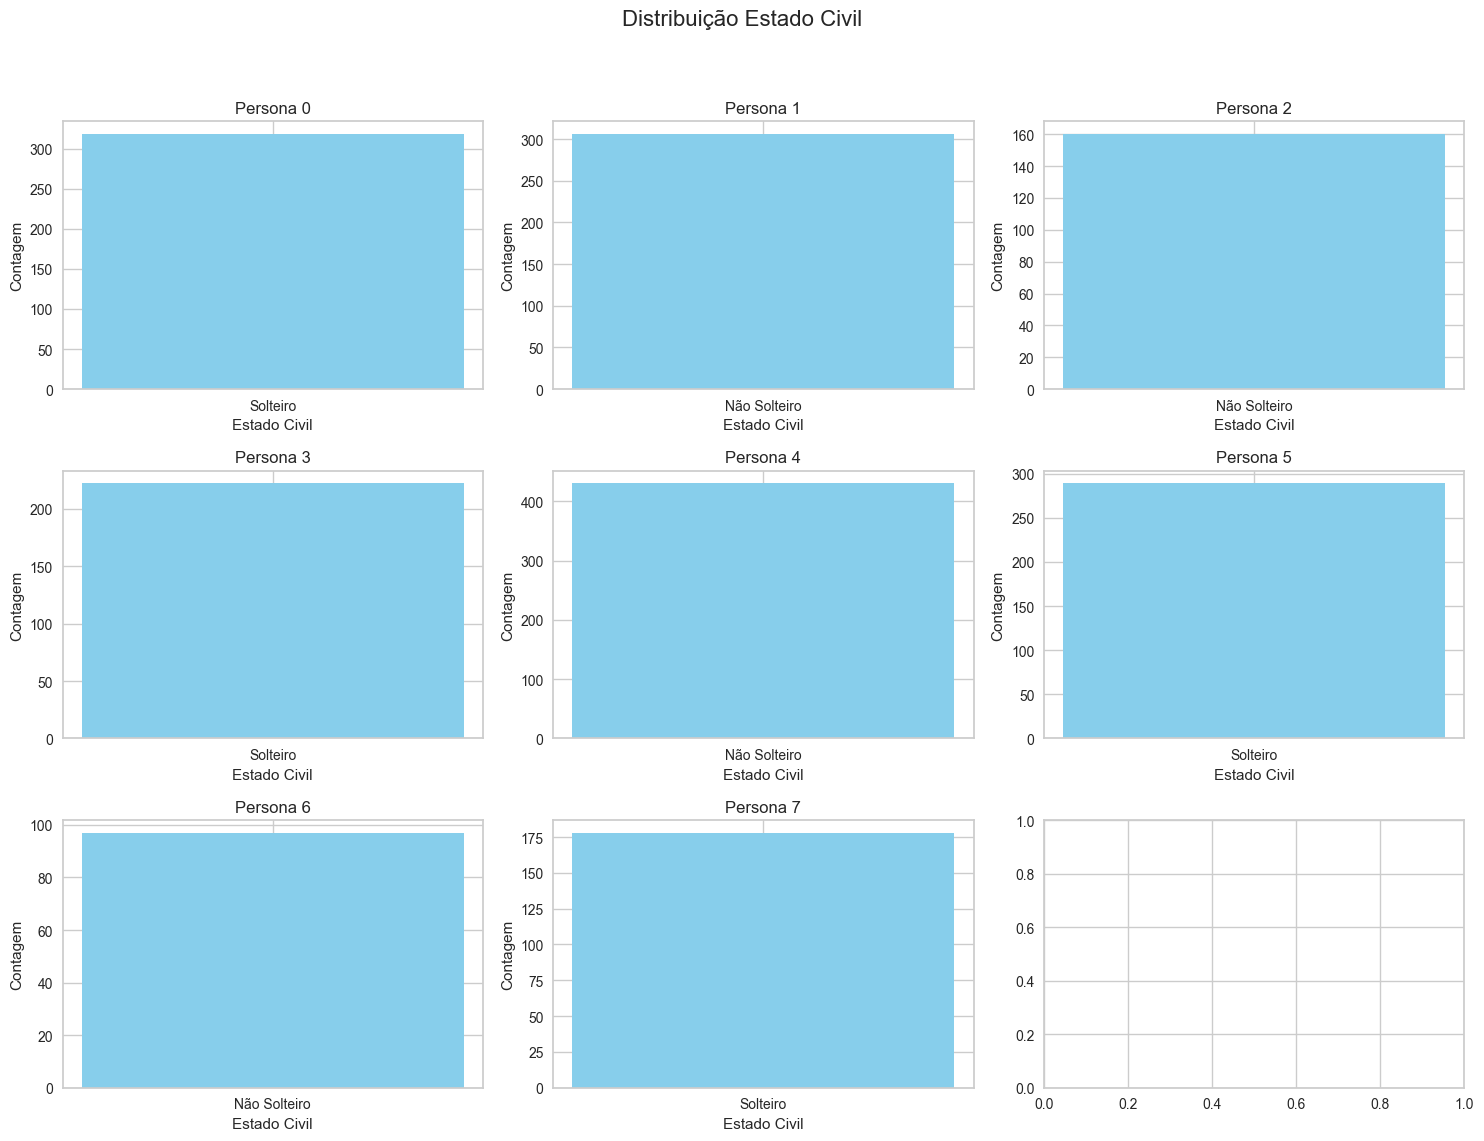

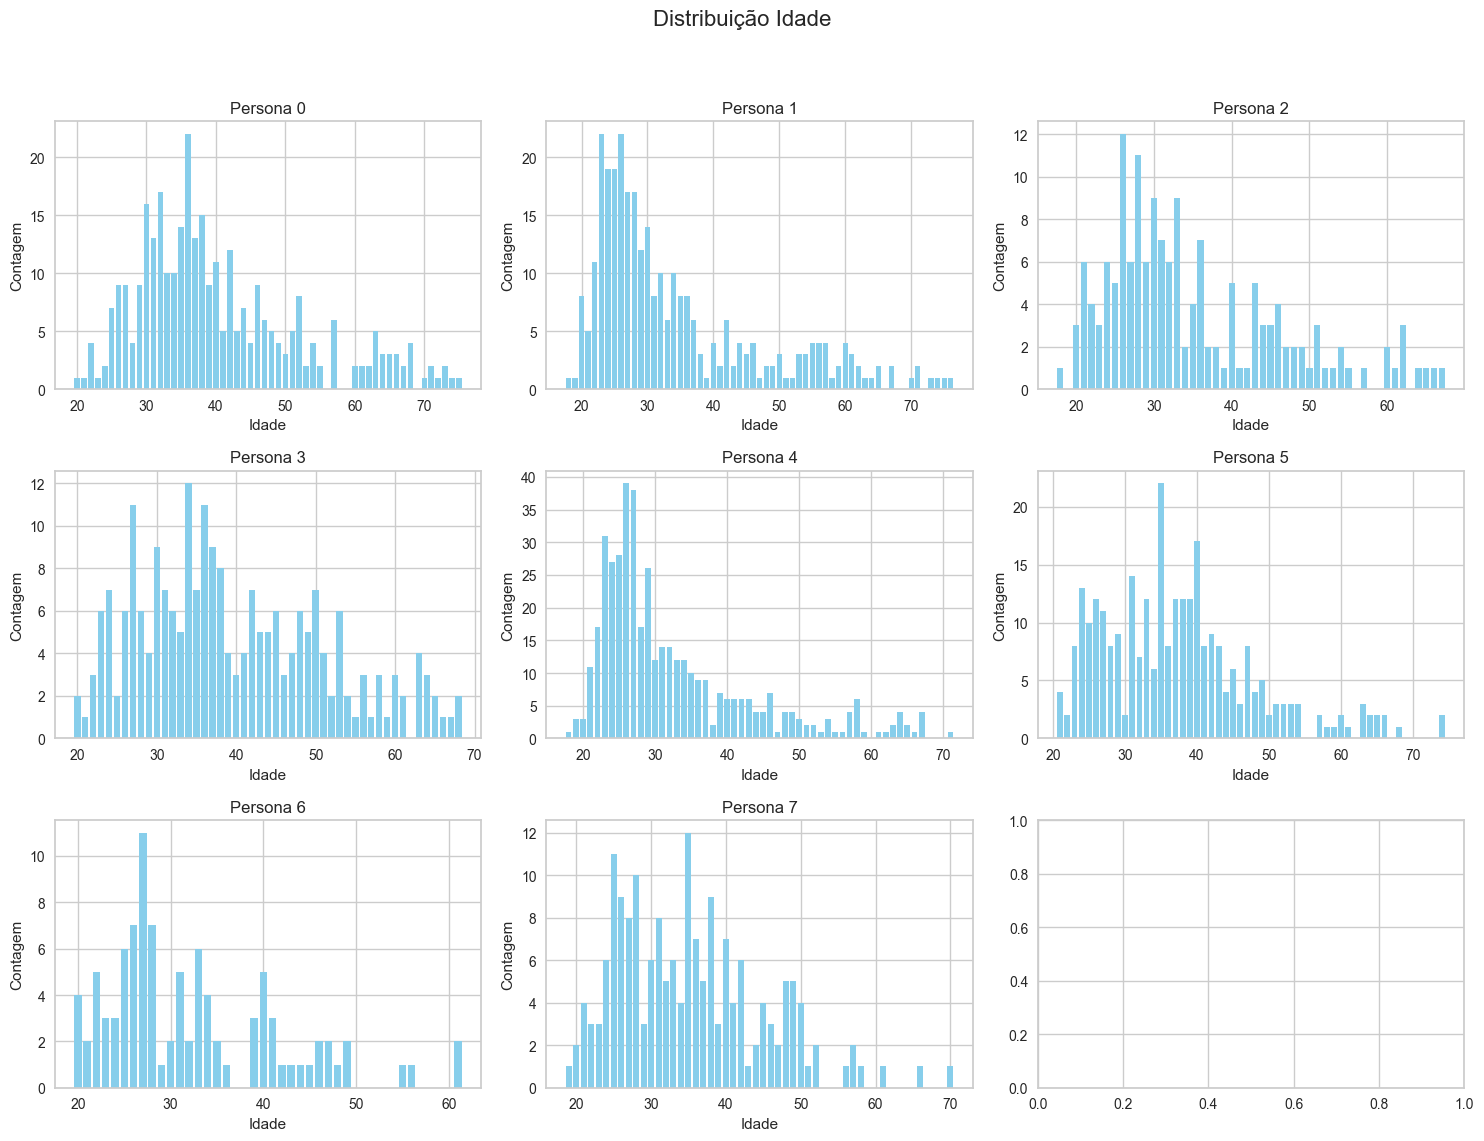

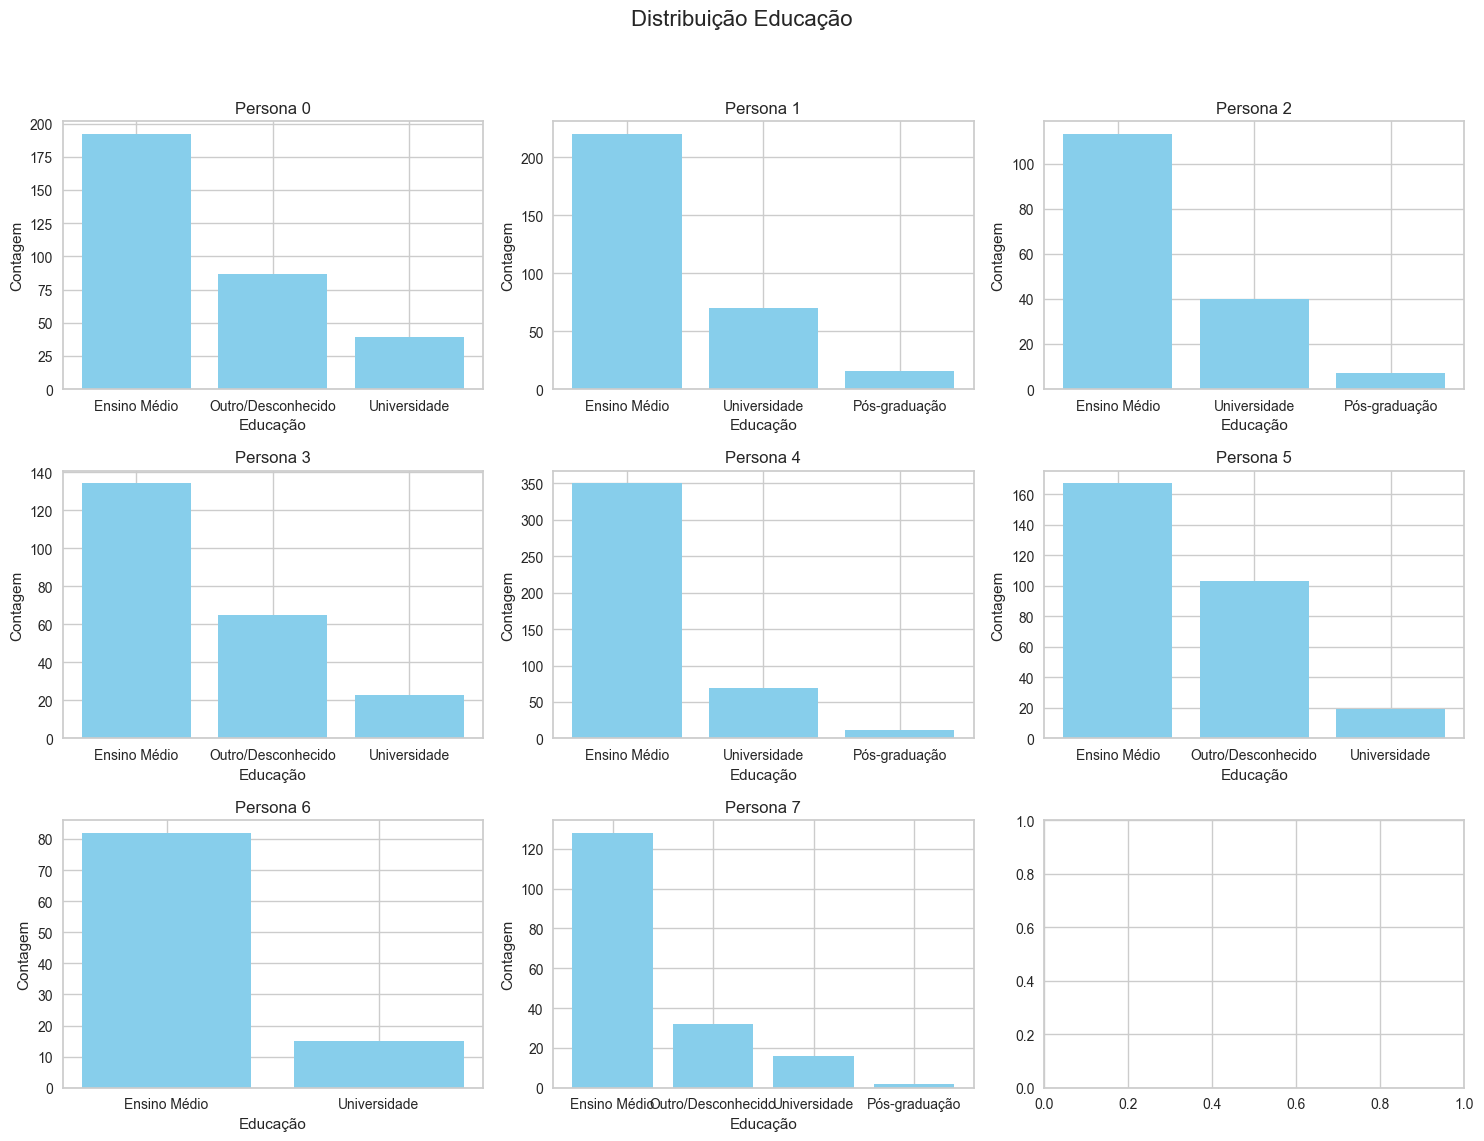

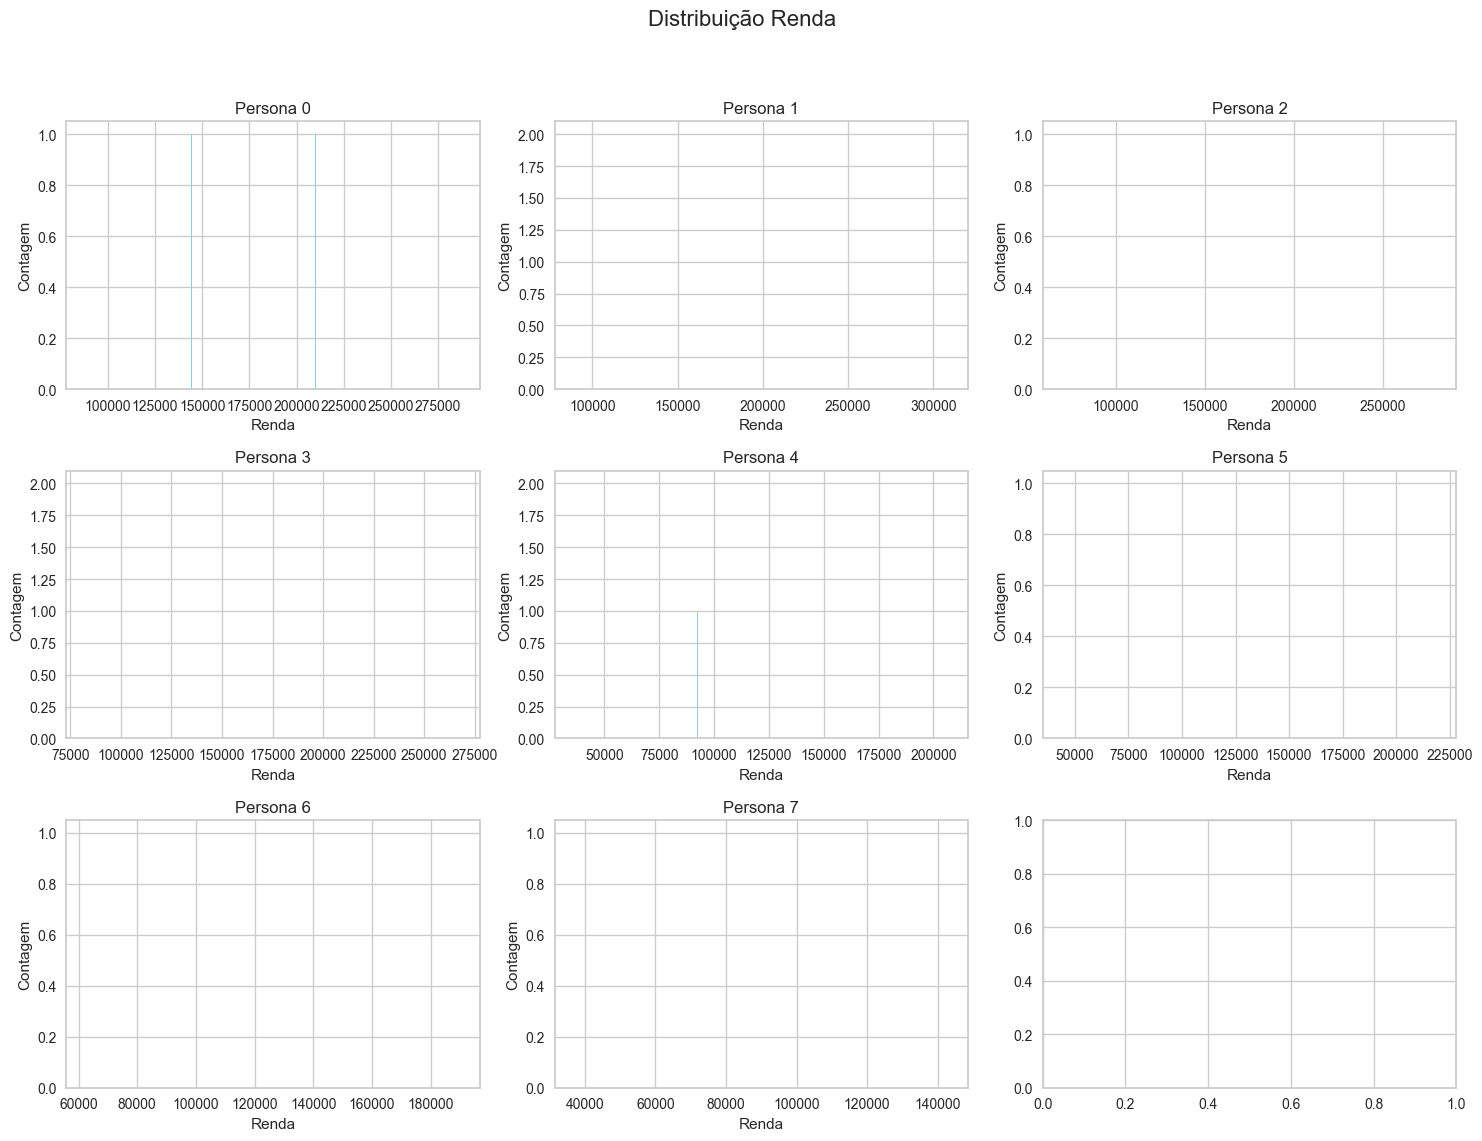

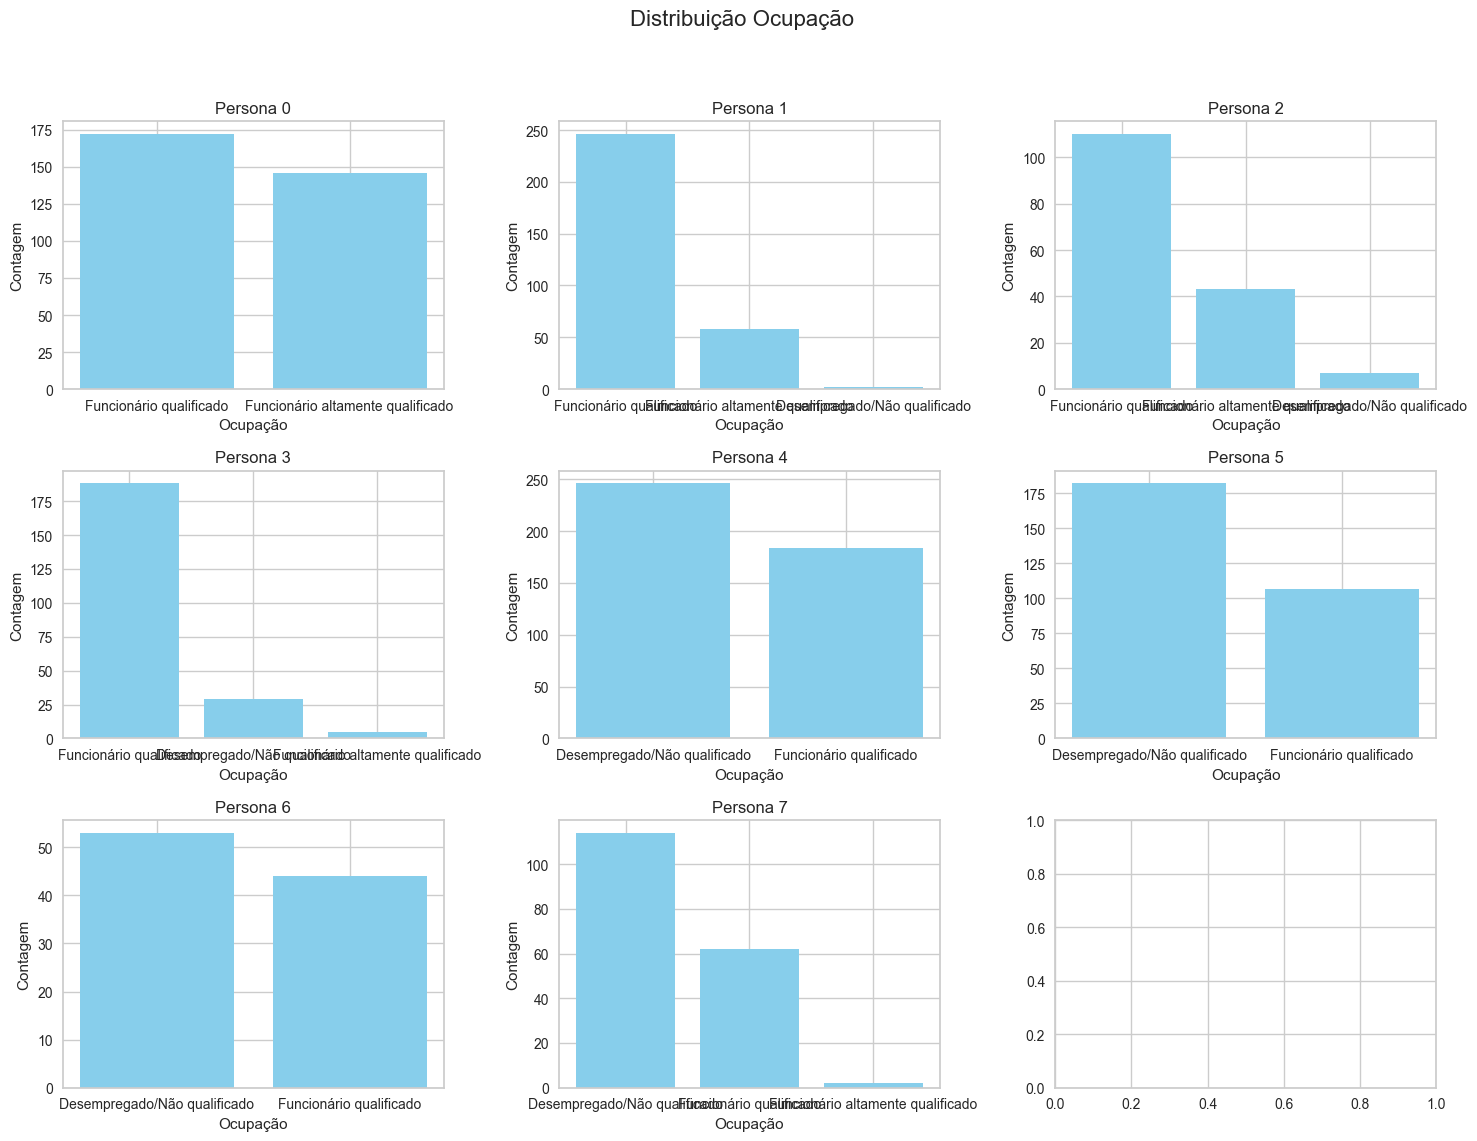

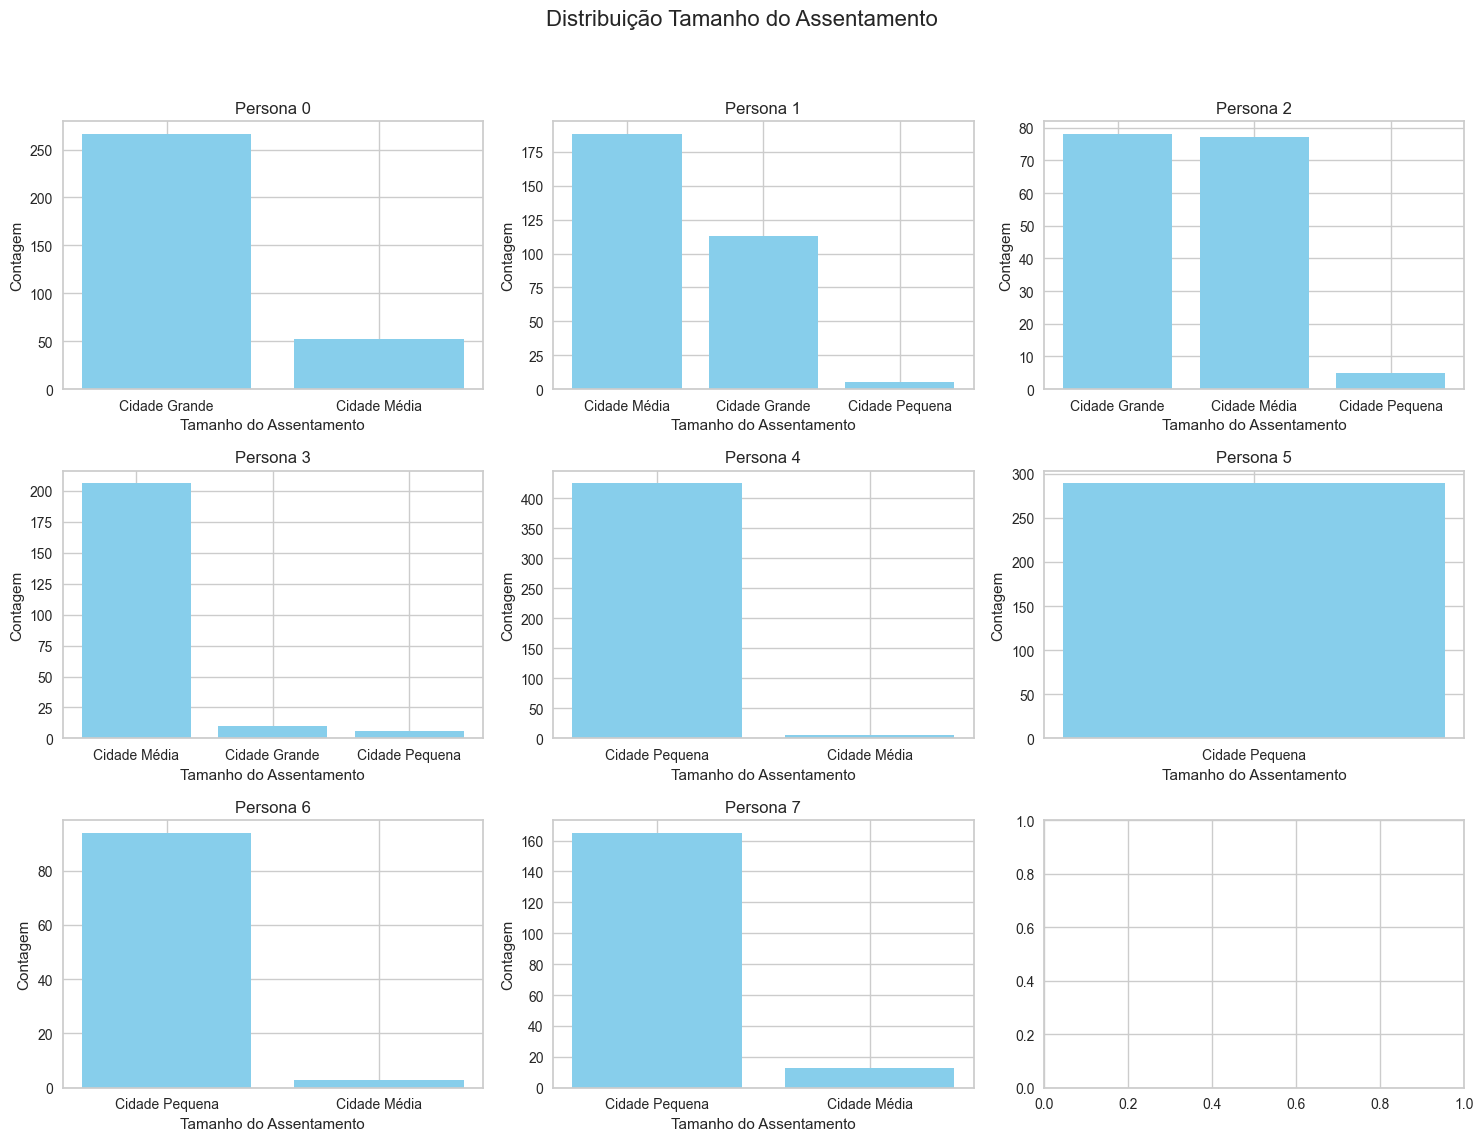

In [68]:
# Get unique clusters
unique_clusters = np.sort(df_eda['Personas'].unique())

# Calculate the number of clusters, columns, and subplots per row
num_clusters = len(unique_clusters)
num_columns = len(df_eda.columns[1:-1])
subplots_per_row = 3

# Calculate the number of rows needed for the subplots
num_rows = (num_clusters + subplots_per_row - 1) // subplots_per_row  # floor division

# Iterate over each column (excluding 'ID' and 'Cluster')
for column in df_eda.columns[1:-1]:
    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 4 * num_rows))
    fig.suptitle(f'Distribuição {column}', fontsize=16)

    # Iterate over each cluster
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i // subplots_per_row, i % subplots_per_row] if num_clusters > 1 else axes[i % subplots_per_row]

        # Fetch data points that belong to the particular cluster
        cluster_data = df_eda[df_eda['Personas'] == cluster]

        # Get the counts of each unique value in the column for the current cluster
        value_counts = cluster_data[column].value_counts()

        # Plot a bar chart showing the counts of each unique value
        ax.bar(value_counts.index, value_counts, color='skyblue')
        ax.set_xlabel(column)
        ax.set_ylabel('Contagem')
        ax.set_title(f'Persona {cluster}')

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

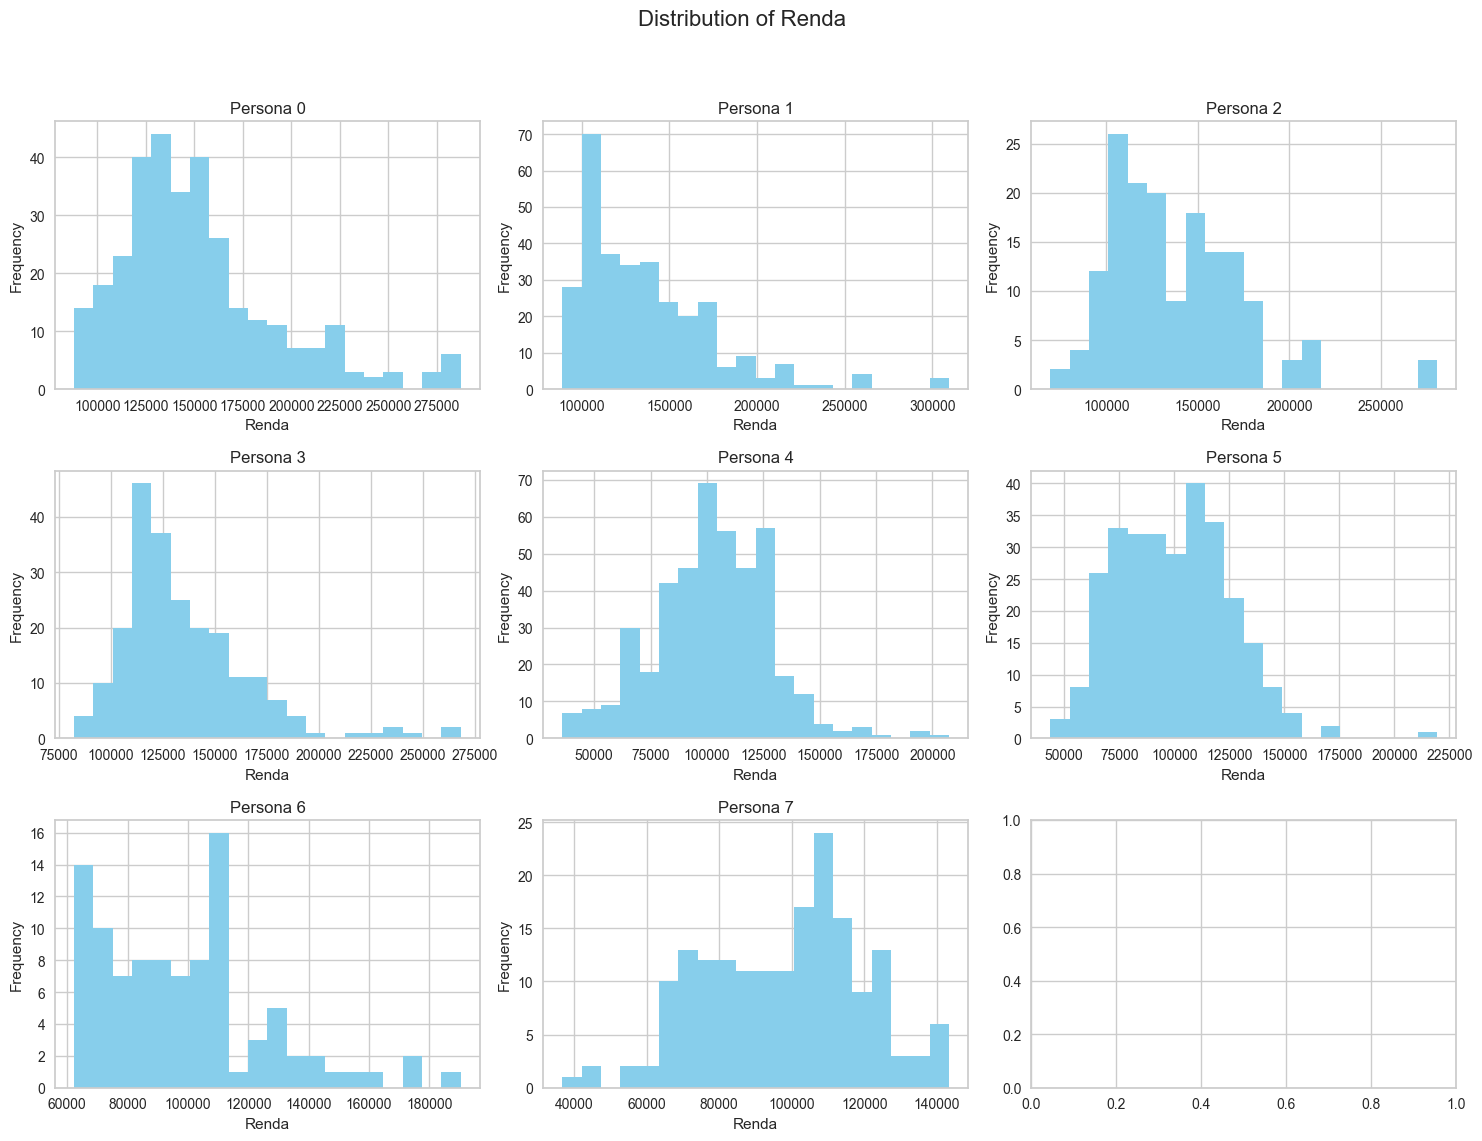

In [71]:
column = 'Renda'  # Set column name to 'Renda'

# Get unique clusters
unique_clusters = np.sort(df_eda['Personas'].unique())

# Calculate the number of clusters, columns, and subplots per row
num_clusters = len(unique_clusters)
num_columns = len(df_eda.columns[1:-1])
subplots_per_row = 3

# Calculate the number of rows needed for the subplots
num_rows = (num_clusters + subplots_per_row - 1) // subplots_per_row  # floor division

# Create a figure with subplots in a grid
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 4 * num_rows))
fig.suptitle(f'Distribution of {column}', fontsize=16)

# Iterate over each cluster
for i, cluster in enumerate(unique_clusters):
    ax = axes[i // subplots_per_row, i % subplots_per_row] if num_clusters > 1 else axes[i % subplots_per_row]

    # Fetch data points that belong to the particular cluster
    cluster_data = df_eda[df_eda['Personas'] == cluster]

    # Get the data for the 'Renda' (Income) column for the current cluster
    income_data = cluster_data[column]

    # Plot a histogram to show the distribution of income
    ax.hist(income_data, bins=20, color='skyblue')  # Adjust bins as needed
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Persona {cluster}')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Conclusão sobre as Personas

### Persona 0
- *Sexo*: Predominantemente Feminino
- *Estado Civil*: Predominantemente Solteiro
- *Idade*: 35-40 anos
- *Educação*: Ensino Médio
- *Renda*: 100k
- *Ocupação*: Desempregado e Qualificado
- *Tamanho do Assentamento*: Cidade Pequena

### Persona 1
- *Sexo*: Predominantemente Masculino
- *Estado Civil*: Predominantemente Solteiro
- *Idade*: 36-40 anos
- *Educação*: Ensino médio e sem graduação
- *Renda*: 100k
- *Ocupação*: Desempregado e Qualificado
- *Tamanho do Assentamento*: Predominantemente de cidade pequena

### Persona 2
- *Sexo*: Predominantemente Feminino
- *Estado Civil*: Predominantemente Não Solteiro
- *Idade*: 20-30 anos
- *Educação*: Ensino Médio e Universidade
- *Renda*: 130k
- *Ocupação*: Qualificado e Altamente Qualificado
- *Tamanho do Assentamento*: Cidade Média e Grande

### Persona 3
- *Sexo*: Predominantemente Masculino
- *Estado Civil*: Predominantemente Não Solteiro
- *Idade*: 25-35 anos
- *Educação*:  Ensino Médio e Universidade
- *Renda*: 130k
- *Ocupação*: Qualificado e Altamente Qualificado
- *Tamanho do Assentamento*: Cidade Grande e Média

## Persona 4
- *Sexo*: Predominantemente Feminino
- *Estado Civil*: Predominantemente Não Solteiro
- *Idade*: 23-29 anos
- *Educação*: Ensino Médio e Universidade
- *Renda*: 100k
- *Ocupação*: Desempregado e Qualificado
- *Tamanho do Assentamento*: Cidade Pequena

## Persona 5
- *Sexo*: Predominantemente Masculino
- *Estado Civil*: Predominantemente Solteiro
- *Idade*: 35-38 anos
- *Educação*: Ensino Médio e Sem Graduação 
- *Renda*: 140k
- *Ocupação*: Qualificado e Altamente Qualificado
- *Tamanho do Assentamento*: Cidade Grande e Média

## Persona 6
- *Sexo*: Predominantemente Masculino
- *Estado Civil*: Predominantemente Não Solteiro
- *Idade*: 26-29 anos
- *Educação*: Ensino Médio
- *Renda*: 95k
- *Ocupação*: Desempregado e Qualificado
- *Tamanho do Assentamento*: Cidade Pequena

## Persona 7
- *Sexo*: Predominantemente Masculino
- *Estado Civil*: Predominantemente Solteiro
- *Idade*: 35-40 anos
- *Educação*: Ensino Médio e Sem Graduação
- *Renda*: 128k
- *Ocupação*: Qualificado e Desempregado
- *Tamanho do Assentamento*: Cidade Média